In [40]:
# ! pip install xclim 

In [41]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 
import seaborn as sns

In [42]:
def read_gcs_zarr(zarr_url, check=False):
    """
    takes in a GCSFS zarr url, bucket token, and returns a dataset 
    Note that you will need to have the proper bucket authentication. 
    """
    fs = gcsfs.GCSFileSystem()
    
    store_path = fs.get_mapper(zarr_url, check=check)
    ds = xr.open_zarr(store_path)
    
    return ds 

Note the location pattern on GCS : gs://downscaled-288ec5ac/diagnostics/RELEASE-v{delivery_version}/{diagnostics_name}/{activity_id}/{institution_id}/{source_id}/{experiment_id}/{member_id}/{table_id}/{variable_id}/{delivery_version}.zarr

ERA-5
gs://downscaled-288ec5ac/diagnostics/RELEASE-{delivery_version}/{diagnostics_name}/reanalysis/ERA5/F320/{variable_id}/{delivery_version}.zarr

In [43]:
plot_dir = '/home/jovyan/tests'

In [44]:
import itertools
import colorcet as cc
clrs = itertools.cycle(sns.color_palette(cc.glasbey, n_colors=17))

In [45]:
model = 'NorESM2-LM'
institution = 'NCC'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

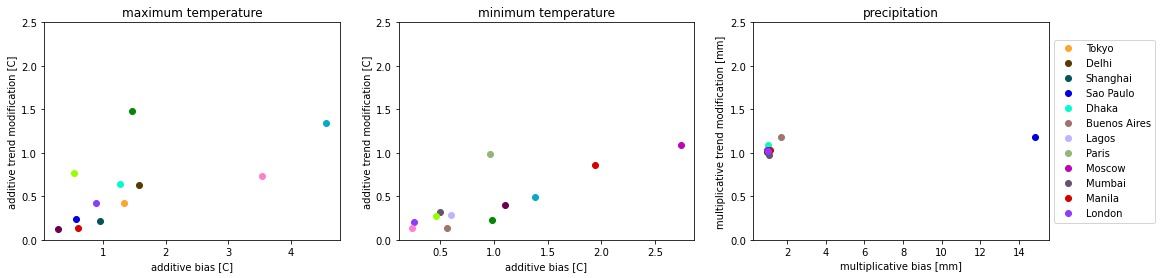

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

x_labels = ['additive bias [C]', 'additive bias [C]','multiplicative bias [mm]']
y_labels = ['additive trend modification [C]', 'additive trend modification [C]','multiplicative trend modification [mm]']

# colors = cm.rainbow(np.linspace(0, 1, len(tasmax_hist_clean.city.values)))
for i, variable in enumerate(['tasmax', 'tasmin', 'precip']):
    # for i, variable in enumerate(['precip']):
    # for i, variable in enumerate(['tasmax', 'tasmin']):
    
    if variable == "precip":
        file_var_name = "pr"
    else:
        file_var_name = variable
    
    var_ssp370_ds = read_gcs_zarr('gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_ds = read_gcs_zarr('gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ssp370_clean = read_gcs_zarr('gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))
    var_hist_clean = read_gcs_zarr('gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/clean-daily-{}-diagnostics/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/{}/v1.1.zarr'.format(variable, file_var_name))

    var_ref = read_gcs_zarr('gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/daily-{}-diagnostics/reanalysis/ERA5/F320/{}/v1.1.zarr'.format(variable, file_var_name))

    city_trend_error = {}
    city_absolute_error = {}
    for city in var_hist_clean.city.values:
        
        if city == 'Cairo' or city == 'Miami' or city == 'Istanbul' or city == 'New York' or city == 'Mexico City':
            pass
        else: 
            
            if variable == 'precip':
                var = 'pr'
            else:
                var = variable 

            if variable == 'precip':
                sim_trend = var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').sum().values / var_hist_clean.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values

                downscale_trend = var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').sum().values / var_hist_ds.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values

                sim_hist = var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values / var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').sum().values

                city_error = np.median(np.abs(downscale_trend / sim_trend))
            else: 

                sim_trend = var_ssp370_clean.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').mean().values - var_hist_clean.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values

                downscale_trend = var_ssp370_ds.sel(city=city)[var].sel(time=slice('2080', '2099')).resample(time='QS-DEC').mean().values - var_hist_ds.sel(city=city)          [var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values

                sim_hist = var_hist_ds.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values - var_ref.sel(city=city)[var].sel(time=slice('1995', '2014')).resample(time='QS-DEC').mean().values

                city_error = np.median(np.abs(downscale_trend - sim_trend))


            city_trend_error[city] = city_error
            abs_error = np.median(np.abs(sim_hist))

            city_absolute_error[city] = abs_error


            axes[i].plot(city_absolute_error[city], city_trend_error[city], 'o', c=next(clrs), label=city)
        axes[i].set_xlabel(x_labels[i])
        axes[i].set_ylabel(y_labels[i])
        axes[i].set_ylim([0, 2.5])

        axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if variable == 'precip': 
            title_variable = 'precipitation'
        elif variable == 'tasmax':
            title_variable = 'maximum temperature'
        else:
            title_variable = 'minimum temperature'
        axes[i].set_title(title_variable)

plt.savefig(os.path.join(plot_dir, 'cities_abs_rel_seasonal_error.png'), 
            bbox_inches='tight', dpi=200)